In [162]:
import os
import pathlib
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import tensorflow as tf
from utils.helper_function import viewRandomImage, lossPlot
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAvgPool2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import numpy as np
import seaborn as sns
import pandas as pd
from tensorflow.keras.utils import load_img, img_to_array
import cv2
import tensorflow.keras.backend as K

In [ ]:
# Check number of file
for dirpaths, dirnames, filenames in os.walk("data"):
    print(dirpaths, len(dirnames), len(filenames))

data 2 0
data/test 2 0
data/test/cat 0 3180
data/test/dog 0 3123
data/train 2 0
data/train/cat 0 9320
data/train/dog 0 9377


In [80]:
# Setup the train and test directories
trainDir = "data/train/"
testDir = "data/test/"

trainData = image_dataset_from_directory(trainDir,
                                         image_size=(224,224),
                                         batch_size=32,
                                         label_mode="binary")

testData = image_dataset_from_directory(testDir,
                                        image_size=(224,224),
                                        batch_size=32,
                                        label_mode="binary",
                                        shuffle=False)

Found 18697 files belonging to 2 classes.
Found 6303 files belonging to 2 classes.


In [ ]:
# Class Name
classNames = trainData.class_names
classNames

['cat', 'dog']

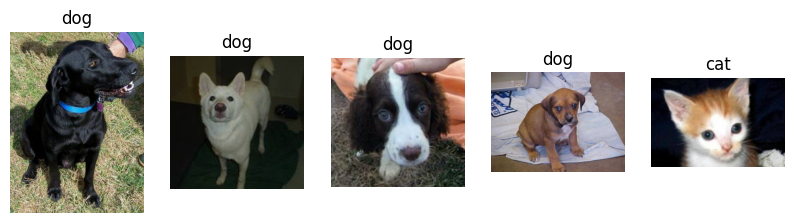

In [ ]:
# Random view image
viewRandomImage(targetDir="data/train/", targetClass=classNames, num=5)

In [ ]:
# Augmentation
augmentData = Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2)], name="augmentation")

In [ ]:
# Create model
input = Input(shape=(224,224,3))
x = augmentData(input)
x = preprocessing.Rescaling(1./255)(x)
x = Conv2D(32, 3, padding="same", activation="relu")(x)
x = MaxPooling2D(2)(x)
x = Dropout(0.2)(x)
x = Conv2D(64, 3, padding="same", activation="relu")(x)
x = MaxPooling2D(2)(x)
x = Dropout(0.2)(x)
x = Conv2D(128, 3, padding="same", activation="relu")(x)
x = MaxPooling2D(2)(x)
x = Dropout(0.2)(x)
x = Flatten()(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.5)(x)
output = Dense(1, activation="sigmoid")(x)
model = Model(input, output)

# Compile the model
model.compile(loss="binary_crossentropy",
              optimizer=Adam(),
              metrics=["accuracy"])

# Setup Callback
es = EarlyStopping(monitor='val_loss', mode='min', patience=3, verbose=1)
mc = ModelCheckpoint('model/modelCustom.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

# Fit the model
history = model.fit(trainData,
                    epochs=5,
                    steps_per_epoch=len(trainData),
                    validation_data=testData,
                    validation_steps=len(testData),
                    callbacks=[es,mc])


Epoch 1/5


2022-09-09 09:24:00.688933: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-09-09 09:24:00.689264: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


585/585 [==============================] - ETA: 0s - loss: 0.7181 - accuracy: 0.5460

2022-09-09 09:27:27.848948: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_accuracy improved from -inf to 0.57941, saving model to model/modelCustom.h5
585/585 [==============================] - 224s 382ms/step - loss: 0.7181 - accuracy: 0.5460 - val_loss: 0.6775 - val_accuracy: 0.5794
Epoch 2/5
585/585 [==============================] - ETA: 0s - loss: 0.6761 - accuracy: 0.5756
Epoch 2: val_accuracy improved from 0.57941 to 0.58401, saving model to model/modelCustom.h5
585/585 [==============================] - 225s 384ms/step - loss: 0.6761 - accuracy: 0.5756 - val_loss: 0.6732 - val_accuracy: 0.5840
Epoch 3/5
585/585 [==============================] - ETA: 0s - loss: 0.6599 - accuracy: 0.6052
Epoch 3: val_accuracy improved from 0.58401 to 0.65937, saving model to model/modelCustom.h5
585/585 [==============================] - 228s 390ms/step - loss: 0.6599 - accuracy: 0.6052 - val_loss: 0.6276 - val_accuracy: 0.6594
Epoch 4/5
585/585 [==============================] - ETA: 0s - loss: 0.6172 - accuracy: 0.6628
Epoch 4: val_accuracy improved fr

keras.callbacks.History

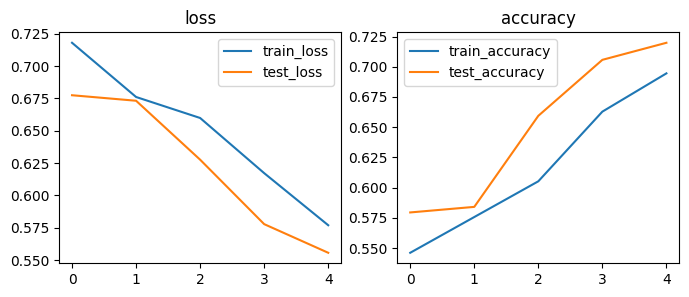

In [ ]:
lossPlot(history)

In [31]:
# Create model transfer learning from pretrain model VGG16

# Create base model
basemodel = VGG16(include_top=False)
basemodel.trainable = False

# Create model
input = Input(shape=(224,224,3))
x = augmentData(input)
x = preprocess_input(x)
x = basemodel(x, training=False)
x = GlobalAvgPool2D()(x)
x = Dense(128, activation="relu")(x)
output = Dense(1, activation="sigmoid")(x)
modelVGG16 = Model(input, output)

# Compile model
modelVGG16.compile(loss="binary_crossentropy",
                   optimizer=Adam(),
                   metrics=["accuracy"])

# Setup Callback
es = EarlyStopping(monitor='val_loss', mode='min', patience=3, verbose=1)
mc = ModelCheckpoint('model/modelVGG16.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

# Fit the model
historyVGG16 = modelVGG16.fit(trainData,
                              epochs=2,
                              steps_per_epoch=len(trainData),
                              validation_data=testData,
                              validation_steps=len(testData),
                              callbacks=[es,mc])


Epoch 1/2


2022-09-09 10:31:52.270340: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


585/585 [==============================] - ETA: 0s - loss: 0.1418 - accuracy: 0.9527

2022-09-09 10:40:04.902860: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_accuracy improved from -inf to 0.97969, saving model to model/modelVGG16.h5
585/585 [==============================] - 636s 1s/step - loss: 0.1418 - accuracy: 0.9527 - val_loss: 0.0604 - val_accuracy: 0.9797
Epoch 2/2
585/585 [==============================] - ETA: 0s - loss: 0.0819 - accuracy: 0.9692
Epoch 2: val_accuracy improved from 0.97969 to 0.98318, saving model to model/modelVGG16.h5
585/585 [==============================] - 617s 1s/step - loss: 0.0819 - accuracy: 0.9692 - val_loss: 0.0491 - val_accuracy: 0.9832


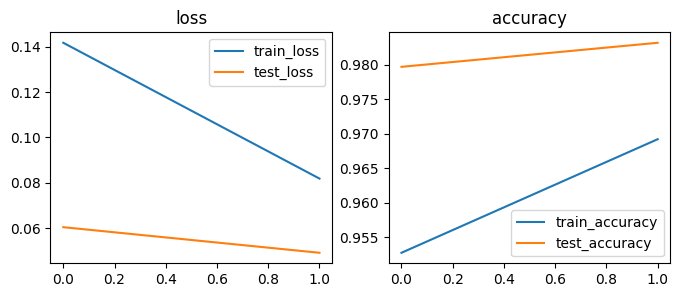

In [32]:
lossPlot(historyVGG16)

In [33]:
# Finetune
basemodel.trainable = True
for layer in basemodel.layers[:-4]:
    layer.trainable = False

modelVGG16.compile(loss="binary_crossentropy",
                   optimizer=Adam(learning_rate=0.0001),
                   metrics="accuracy")

finetuneEpochs = 4

historyVGG16_FT = modelVGG16.fit(trainData,
                                 epochs=finetuneEpochs,
                                 steps_per_epoch=len(trainData),
                                 validation_data=testData,
                                 validation_steps=len(testData),
                                 initial_epoch=historyVGG16.epoch[-1]+1,
                                 callbacks=[es,mc])

Epoch 3/4


2022-09-09 11:00:28.352114: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


585/585 [==============================] - ETA: 0s - loss: 0.1015 - accuracy: 0.9612

2022-09-09 11:08:18.875854: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 3: val_accuracy did not improve from 0.98318
585/585 [==============================] - 607s 1s/step - loss: 0.1015 - accuracy: 0.9612 - val_loss: 0.0694 - val_accuracy: 0.9778
Epoch 4/4
585/585 [==============================] - ETA: 0s - loss: 0.0652 - accuracy: 0.9758
Epoch 4: val_accuracy improved from 0.98318 to 0.98683, saving model to model/modelVGG16.h5
585/585 [==============================] - 687s 1s/step - loss: 0.0652 - accuracy: 0.9758 - val_loss: 0.0377 - val_accuracy: 0.9868


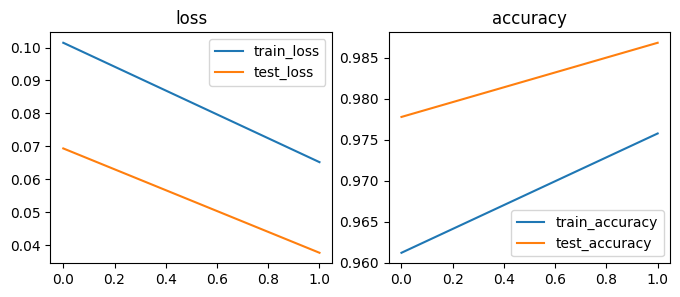

In [34]:
lossPlot(historyVGG16_FT)

In [37]:
# Prediction
yPred = modelVGG16.predict(testData, verbose=0)
yPred

array([[4.1602400e-19],
       [1.3129015e-16],
       [1.9386607e-18],
       ...,
       [1.0000000e+00],
       [9.7181445e-01],
       [8.8699043e-01]], dtype=float32)

In [61]:
# Accuracy
yPredClass = np.squeeze(np.round(yPred).astype("int")).tolist()
yTest = []
for image, label in testData.unbatch():
    yTest.append(int(label.numpy()[0]))

accuracy = accuracy_score(yTest, yPredClass)
print(f"accuracy: {accuracy}")

accuracy: 0.9868316674599397


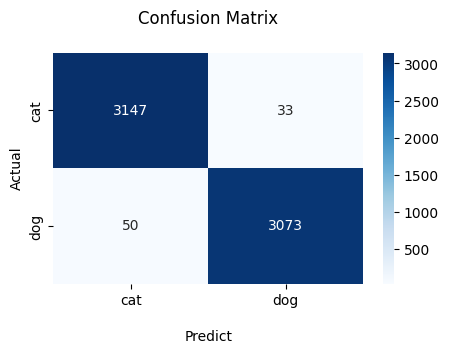

In [69]:
# Plot confusion matrix
cfMatrix = confusion_matrix(yTest, yPredClass)

plt.figure(figsize=(5,3))
ax = sns.heatmap(cfMatrix, annot=True, cmap='Blues', fmt="g")

ax.set_title('Confusion Matrix\n');
ax.set_xlabel('\nPredict')
ax.set_ylabel('Actual');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(classNames)
ax.yaxis.set_ticklabels(classNames)

## Display the visualization of the Confusion Matrix.
plt.show()

In [71]:
# Classification Report 
print(classification_report(yTest, yPredClass))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      3180
           1       0.99      0.98      0.99      3123

    accuracy                           0.99      6303
   macro avg       0.99      0.99      0.99      6303
weighted avg       0.99      0.99      0.99      6303



In [128]:
# Summary result to dataframe
imgPath = []
for imgpath in testData.list_files("data/test/*/*.*", shuffle=False):
    imgPath.append(imgpath.numpy())

dataResult = pd.DataFrame({"imgpath" : imgPath ,
                           "actual" : yTest ,
                           "predict" : yPredClass ,
                           "predictProb" : np.round(np.squeeze(yPred),2),
                           "actualLebel" : [classNames[i] for i in yTest],
                           "predictLabel" : [classNames[i] for i in yPredClass]
                           })
dataResult['iscorrect'] = dataResult["actual"] == dataResult["predict"]
dataResult

,imgpath,actual,predict,predictProb,actualLebel,predictLabel,iscorrect
0,b'data/test/cat/cat.1.jpg',0,0,0.00,cat,cat,True
1,b'data/test/cat/cat.100.jpg',0,0,0.00,cat,cat,True
2,b'data/test/cat/cat.10000.jpg',0,0,0.00,cat,cat,True
3,b'data/test/cat/cat.10001.jpg',0,0,0.00,cat,cat,True
4,b'data/test/cat/cat.10002.jpg',0,0,0.00,cat,cat,True
...,...,...,...,...,...,...,...
6298,b'data/test/dog/dog.9989.jpg',1,1,1.00,dog,dog,True
6299,b'data/test/dog/dog.999.jpg',1,1,1.00,dog,dog,True
6300,b'data/test/dog/dog.9996.jpg',1,1,1.00,dog,dog,True
6301,b'data/test/dog/dog.9997.jpg',1,1,0.97,dog,dog,True


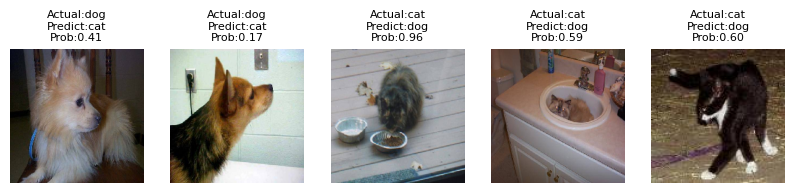

In [132]:
# Visualize predict misstake
dataFalse = dataResult[dataResult["iscorrect"]==False]
dataFalseRandom = dataFalse.sample(5)
plt.figure(figsize=(10,5))
for i, row in enumerate(dataFalseRandom.itertuples()):
    plt.subplot(1, 5, i+1)
    img = load_img(row.imgpath, target_size=(224,224))
    plt.imshow(img)
    plt.title(f"Actual:{row.actualLebel}\nPredict:{row.predictLabel}\nProb:{row.predictProb:.2f}", fontsize=8)
    plt.axis(False)